In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
import joblib
from keras_tuner import Objective

warnings.simplefilter("ignore", UserWarning)

In [12]:
np.random.seed(5)

In [13]:
df = pd.read_csv("./datasets/DCFC_load.csv")
load_df = df.drop((['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7']),axis=1)
time = pd.to_datetime(load_df['Time'], format='%d/%m/%y %H:%M')

time_train = time[:23328]
x_train = load_df["PowerkW2"][:23328]

time_cv = time[23328:]
x_cv = load_df["PowerkW2"][23328:]

In [14]:
load_df

,Time,PowerkW2
0,01/01/22 0:00,23.146460
1,01/01/22 0:15,17.971620
2,01/01/22 0:30,6.735884
3,01/01/22 0:45,0.000000
4,01/01/22 1:00,0.000000
...,...,...
35035,31/12/22 22:42,15.200730
35036,31/12/22 22:57,0.000000
35037,31/12/22 23:12,0.000000
35038,31/12/22 23:27,0.000000


In [15]:
# We had not scaled the data before and we will do it now for better results and try and see how does it make
# things better 

scaler = MinMaxScaler()

In [16]:
x_train_reshaped = x_train.values.reshape(-1,1)

In [17]:
# Save the scaler and its parameters
joblib.dump(scaler, 'scaler_model.joblib')

# Load the scaler for later use
loaded_scaler = joblib.load('scaler_model.joblib')

In [18]:
x_cv_reshaped = x_cv.values.reshape(-1,1)

In [19]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [20]:
# Creating the dataset
# Parameters

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [21]:
# Generate the dataset windows
dataset = windowed_dataset(x_train_reshaped, window_size, batch_size, shuffle_buffer_size)

validation_dataset = windowed_dataset(x_cv_reshaped, window_size, batch_size, shuffle_buffer_size)

In [15]:
def build_model(hp):
    model = Sequential()
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_1',min_value=32,max_value=320,step=32),return_sequences = True)))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_2',min_value=32,max_value=320,step=32),return_sequences = True)))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_3',min_value=32,max_value=320,step=32))))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.5,step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Lambda(lambda x: x * 100.0))
    # Create an instance of the Adam optimizer with a variable learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log'))
    model.compile(loss='mean_squared_error', optimizer= optimizer ,metrics = ['mse' , 'mae'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=50,
        executions_per_trial=1,
        directory='tuning_directory_mse_3layer',  # Specify a directory for storing tuning results
        project_name='my_lstm_tuning'
        )

Reloading Tuner from tuning_directory_mse_3layer/my_lstm_tuning/tuner0.json


In [19]:
tuner.search(
        x=dataset,
        epochs=20,
        validation_data=validation_dataset,
        callbacks = [early_stopping]
)

In [20]:
tuner.oracle.get_best_trials(1)[0].hyperparameters.values

{'LSTM_1': 128,
 'LSTM_2': 192,
 'LSTM_3': 288,
 'Dropout_rate': 0.30000000000000004,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.0007748510631571134}

In [21]:
tuner.oracle.get_best_trials(1)[0].trial_id

'16'

In [22]:
best_model = tuner.get_best_models(num_models=1)[0]


In [23]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 256)           133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 384)           689664    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 576)               1550592   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                        

In [29]:
tuner.results_summary()

Results summary
Results in tuning_directory_mse_3layer/my_lstm_tuning
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 16 summary
Hyperparameters:
LSTM_1: 128
LSTM_2: 192
LSTM_3: 288
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
learning_rate: 0.0007748510631571134
Score: 66.15218353271484

Trial 25 summary
Hyperparameters:
LSTM_1: 224
LSTM_2: 320
LSTM_3: 160
Dropout_rate: 0.2
dense_activation: sigmoid
learning_rate: 0.0004028122259221392
Score: 66.16852569580078

Trial 48 summary
Hyperparameters:
LSTM_1: 96
LSTM_2: 256
LSTM_3: 224
Dropout_rate: 0.1
dense_activation: sigmoid
learning_rate: 0.0003008851184974976
Score: 66.17681121826172

Trial 26 summary
Hyperparameters:
LSTM_1: 32
LSTM_2: 32
LSTM_3: 224
Dropout_rate: 0.30000000000000004
dense_activation: relu
learning_rate: 0.0006337471468379436
Score: 66.28330993652344

Trial 41 summary
Hyperparameters:
LSTM_1: 224
LSTM_2: 32
LSTM_3: 288
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lear

In [25]:
# Reduce the original series
forecast_series_LSTM = x_cv_reshaped

# Use helper function to generate predictions
forecast_LSTM = model_forecast(best_model, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
results_LSTM = forecast_LSTM.squeeze()

366/366 [==============================] - 18s 48ms/step


In [26]:
mse = tf.keras.metrics.mean_squared_error(results_LSTM, x_cv_reshaped[19:].squeeze()).numpy()
mae = tf.keras.metrics.mean_absolute_error(results_LSTM, x_cv_reshaped[19:].squeeze()).numpy()

print("MSE in original scale:", mse)
print("MAE in original scale:", mae)


MSE in original scale: 60.415966451979436
MAE in original scale: 5.2217431684725


In [33]:
# Verifying if training the built model to the best epoch gives the same result so that the heavy files can 
# be deleted and this notebook pushed to GitHub

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Lambda

# Create the model
verification_model = Sequential(name="verification_model")
verification_model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]))
verification_model.add(Bidirectional(LSTM(128, return_sequences=True)))
verification_model.add(Bidirectional(LSTM(192, return_sequences=True)))
verification_model.add(Bidirectional(LSTM(288)))
verification_model.add(Dropout(0.30000000000000004))
verification_model.add(Dense(1))
verification_model.add(Lambda(lambda x: x * 100.0))  # Assuming you want to reduce to (None, 1)
optimizer = Adam(learning_rate= 0.0007748510631571134)
# Compile the model
verification_model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
verification_model.summary()



Model: "verification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 20, 256)           133120    
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 20, 384)           689664    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 576)               1550592   
 ional)                                                          
                                                                 
 dropout_3 (Dropout)         (None, 576)               0         
                                                

In [34]:
verification_model.fit(x=dataset , epochs = 12)

Epoch 1/12
729/729 [==============================] - 108s 143ms/step - loss: 119.6834
Epoch 2/12
729/729 [==============================] - 100s 137ms/step - loss: 75.3776
Epoch 3/12
729/729 [==============================] - 99s 136ms/step - loss: 72.4089
Epoch 4/12
729/729 [==============================] - 115s 157ms/step - loss: 71.2511
Epoch 5/12
729/729 [==============================] - 112s 154ms/step - loss: 69.7625
Epoch 6/12
729/729 [==============================] - 113s 154ms/step - loss: 69.2889
Epoch 7/12
729/729 [==============================] - 113s 155ms/step - loss: 68.4577
Epoch 8/12
729/729 [==============================] - 112s 154ms/step - loss: 68.1868
Epoch 9/12
729/729 [==============================] - 115s 158ms/step - loss: 67.8002
Epoch 10/12
729/729 [==============================] - 110s 151ms/step - loss: 67.4942
Epoch 11/12
729/729 [==============================] - 113s 155ms/step - loss: 67.4975
Epoch 12/12
729/729 [==============================]

In [39]:
# Reduce the original series
forecast_series_LSTM = x_cv_reshaped

# Use helper function to generate predictions
forecast_LSTM = model_forecast(verification_model, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
verification_results_LSTM = forecast_LSTM.squeeze()

366/366 [==============================] - 15s 41ms/step


In [40]:
mse = tf.keras.metrics.mean_squared_error(verification_results_LSTM, x_cv_reshaped[19:].squeeze()).numpy()
mae = tf.keras.metrics.mean_absolute_error(verification_results_LSTM, x_cv_reshaped[19:].squeeze()).numpy()

print("MSE in original scale:", mse)
print("MAE in original scale:", mae)

MSE in original scale: 50.565474669066404
MAE in original scale: 5.198935348462049


In [11]:
# So technically it provides the best step and that gives an even better result.

In [12]:
def build_model_2layer(hp):
    model = Sequential()
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_1',min_value=32,max_value=320,step=32),return_sequences = True)))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_3',min_value=32,max_value=320,step=32))))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.5,step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Lambda(lambda x: x * 100.0))
    # Create an instance of the Adam optimizer with a variable learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log'))
    model.compile(loss='mean_squared_error', optimizer= optimizer ,metrics = ['mse' , 'mae'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)    

In [ ]:
tuner= RandomSearch(
        build_model_2layer,
        objective='val_mape',
        max_trials=25,
        executions_per_trial=1,
        directory='tuning_directory_mse_2layer',  # Specify a directory for storing tuning results
        project_name='my_lstm_tuning_2layer_mse',
        )

In [22]:
# tuner.search(
#         x=dataset,
#         epochs=20,
#         validation_data=validation_dataset,
#         callbacks = [early_stopping]
# )

In [35]:
tuner.oracle.get_best_trials(1)[0].hyperparameters.values

{'LSTM_1': 320,
 'LSTM_3': 160,
 'Dropout_rate': 0.1,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.00014496450085031546}

In [36]:
tuner.oracle.get_best_trials(1)[0].trial_id

'00'

In [37]:
tuner.results_summary()

Results summary
Results in tuning_directory_mse_2layer/my_lstm_tuning_2layer_mse
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 00 summary
Hyperparameters:
LSTM_1: 320
LSTM_3: 160
Dropout_rate: 0.1
dense_activation: sigmoid
learning_rate: 0.00014496450085031546
Score: 86.87268829345703

Trial 12 summary
Hyperparameters:
LSTM_1: 320
LSTM_3: 192
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
learning_rate: 0.0002869314776481352
Score: 86.99288177490234

Trial 19 summary
Hyperparameters:
LSTM_1: 160
LSTM_3: 192
Dropout_rate: 0.5
dense_activation: sigmoid
learning_rate: 0.0006709934026096912
Score: 87.05364990234375

Trial 13 summary
Hyperparameters:
LSTM_1: 320
LSTM_3: 256
Dropout_rate: 0.2
dense_activation: sigmoid
learning_rate: 0.0005185908177918626
Score: 87.12567901611328

Trial 18 summary
Hyperparameters:
LSTM_1: 224
LSTM_3: 192
Dropout_rate: 0.2
dense_activation: sigmoid
learning_rate: 0.0009719857082698608
Score: 87.30912780761719

Trial 06 s

In [38]:
best_model_mse_2 = tuner.get_best_models(num_models=1)[0]

In [39]:
best_model_mse_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 640)           824320    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 320)               1025280   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 1)                 321       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0

In [40]:
# Reduce the original series
forecast_series_LSTM = x_cv_reshaped

# Use helper function to generate predictions
forecast_LSTM = model_forecast(best_model_mse_2, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
results_2_LSTM_mse = forecast_LSTM.squeeze()

366/366 [==============================] - 11s 27ms/step


In [41]:
mse = tf.keras.metrics.mean_squared_error(results_2_LSTM_mse, x_cv_reshaped[19:].squeeze()).numpy()
mae = tf.keras.metrics.mean_absolute_error(results_2_LSTM_mse, x_cv_reshaped[19:].squeeze()).numpy()

print("MSE in original scale:", mse)
print("MAE in original scale:", mae)

MSE in original scale: 53.687507709959114
MAE in original scale: 5.066923251284806


In [79]:
# Verifying if training the built model to the best epoch gives the same result so that the heavy files can 
# be deleted and this notebook pushed to GitHub

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Lambda

# Create the model
verification_model_2layer_mse = Sequential(name="verification_model")
verification_model_2layer_mse.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]))
verification_model_2layer_mse.add(Bidirectional(LSTM(64, return_sequences=True)))
verification_model_2layer_mse.add(Bidirectional(LSTM(224)))
verification_model_2layer_mse.add(Dropout(0.2))
verification_model_2layer_mse.add(Dense(1 , activation = 'relu'))
verification_model_2layer_mse.add(Lambda(lambda x: x * 100.0))  
optimizer = Adam(learning_rate= 0.0007635327985664222)
# Compile the model
verification_model_2layer_mse.compile(optimizer='adam', loss='mean_absolute_error')

# Print the model summary
verification_model_2layer_mse.summary()


Model: "verification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_21 (Lambda)          (None, 20, 1)             0         
                                                                 
 bidirectional_22 (Bidirect  (None, 20, 128)           33792     
 ional)                                                          
                                                                 
 bidirectional_23 (Bidirect  (None, 448)               632576    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 448)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 449       
                                                                 
 lambda_22 (Lambda)          (None, 1)          

In [80]:
verification_model_2layer_mse.fit(x=dataset , epochs = 1)

729/729 [==============================] - 50s 63ms/step - loss: 5.4650


In [81]:
# Reduce the original series
forecast_series_LSTM = x_cv_reshaped

# Use helper function to generate predictions
forecast_LSTM = model_forecast(verification_model_2layer_mse, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
verification_results_LSTM_mse_2layer = forecast_LSTM.squeeze()

366/366 [==============================] - 9s 22ms/step


In [82]:
mse = tf.keras.metrics.mean_squared_error(verification_results_LSTM_mse_2layer, x_cv_reshaped[19:].squeeze()).numpy()
mape = tf.keras.metrics.mean_absolute_percentage_error(verification_results_LSTM_mse_2layer, x_cv_reshaped[19:].squeeze()).numpy()
mae = tf.keras.metrics.mean_absolute_error(verification_results_LSTM_mse_2layer, x_cv_reshaped[19:].squeeze()).numpy()

print("MSE in original scale:", mse)
print("MAPE in original scale:", mape)
print("MAE in original scale:", mae)

MSE in original scale: 175.19055630866296
MAPE in original scale: 6646746389.03532
MAE in original scale: 6.64674638903532


In [83]:
def plot_series_2(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

        for series_num in series:
        # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

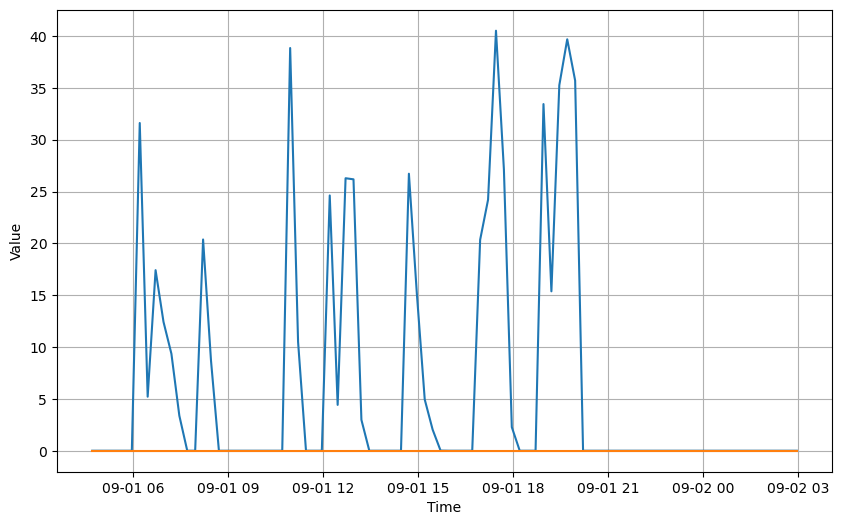

In [84]:
plot_series_2(time_cv[19:109], (x_cv[19:109], verification_results_LSTM_mse_2layer[:90]))

In [ ]:
def build_model_2layer(hp):
    model = Sequential()
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_1',min_value=32,max_value=320,step=32),return_sequences = True)))
    model.add(Bidirectional(LSTM(hp.Int('LSTM_2',min_value=32,max_value=320,step=32))))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0.1,max_value=0.5,step=0.1)))
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Lambda(lambda x: x * 100.0))
    # Create an instance of the Adam optimizer with a variable learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log'))
    model.compile(loss='Huber', optimizer= optimizer ,metrics = ['mse' , 'mae'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)    

In [42]:
tuner= RandomSearch(
        build_model_2layer,
        objective='val_mse',
        max_trials=25,
        executions_per_trial=1,
        directory='tuning_directory_huber_2layer',  # Specify a directory for storing tuning results
        project_name='my_lstm_tuning_2layer_huber',
        overwrite = True
    
        )

In [43]:
tuner.search(
        x=dataset,
        epochs=20,
        validation_data=validation_dataset,
        callbacks = [early_stopping]
)

Trial 25 Complete [00h 39m 04s]
val_mse: 86.754150390625

Best val_mse So Far: 86.754150390625
Total elapsed time: 06h 33m 14s


In [44]:
tuner.oracle.get_best_trials(1)[0].hyperparameters.values

{'LSTM_1': 320,
 'LSTM_3': 320,
 'Dropout_rate': 0.2,
 'dense_activation': 'sigmoid',
 'learning_rate': 0.0007573740073903525}

In [45]:
tuner.oracle.get_best_trials(1)[0].trial_id

'24'

In [46]:
tuner.results_summary()

Results summary
Results in tuning_directory_huber_2layer/my_lstm_tuning_2layer_huber
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 24 summary
Hyperparameters:
LSTM_1: 320
LSTM_3: 320
Dropout_rate: 0.2
dense_activation: sigmoid
learning_rate: 0.0007573740073903525
Score: 86.754150390625

Trial 19 summary
Hyperparameters:
LSTM_1: 320
LSTM_3: 160
Dropout_rate: 0.1
dense_activation: sigmoid
learning_rate: 0.0007441425131576781
Score: 87.22559356689453

Trial 10 summary
Hyperparameters:
LSTM_1: 288
LSTM_3: 224
Dropout_rate: 0.5
dense_activation: sigmoid
learning_rate: 0.000253197215819266
Score: 87.23004913330078

Trial 08 summary
Hyperparameters:
LSTM_1: 224
LSTM_3: 288
Dropout_rate: 0.1
dense_activation: sigmoid
learning_rate: 0.00017849165322769413
Score: 87.36618041992188

Trial 18 summary
Hyperparameters:
LSTM_1: 192
LSTM_3: 256
Dropout_rate: 0.2
dense_activation: sigmoid
learning_rate: 0.000117187953887789
Score: 87.37356567382812

Trial 23 summary
Hyperpara

In [47]:
best_model_huber_2 = tuner.get_best_models(num_models=1)[0]


In [48]:
best_model_huber_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 640)           824320    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 640)               2460160   
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0

In [49]:
split_time = 23328

# Reduce the original series
forecast_series_LSTM = x_cv_reshaped

# Use helper function to generate predictions
forecast_LSTM = model_forecast(best_model_huber_2, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
results_2_LSTM_huber = forecast_LSTM.squeeze()

366/366 [==============================] - 27s 71ms/step


In [50]:
mse = tf.keras.metrics.mean_squared_error(results_2_LSTM_huber, x_cv_reshaped[19:].squeeze()).numpy()
mae = tf.keras.metrics.mean_absolute_error(results_2_LSTM_huber, x_cv_reshaped[19:].squeeze()).numpy()

print("MSE in original scale:", mse)
print("MAE in original scale:", mae)


MSE in original scale: 57.01393987635329
MAE in original scale: 5.1538034033654405


In [54]:
# Verifying if training the built model to the best epoch gives the same result so that the heavy files can 
# be deleted and this notebook pushed to GitHub

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Lambda

# Create the model
verification_model_2layer_huber = Sequential(name="verification_model")
verification_model_2layer_huber.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[window_size]))
verification_model_2layer_huber.add(Bidirectional(LSTM(96, return_sequences=True)))
verification_model_2layer_huber.add(Bidirectional(LSTM(288)))
verification_model_2layer_huber.add(Dropout(0.5))
verification_model_2layer_huber.add(Dense(1, activation = 'sigmoid'))
verification_model_2layer_huber.add(Lambda(lambda x: x * 100.0))  # Assuming you want to reduce to (None, 1)
optimizer = Adam(learning_rate= 0.0003686469542052108)
# Compile the model
verification_model_2layer_huber.compile(optimizer='adam', loss='huber')

# Print the model summary
verification_model_2layer_huber.summary()


Model: "verification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 20, 192)           75264     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 576)               1108224   
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 576)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 577       
                                                                 
 lambda_7 (Lambda)           (None, 1)          

In [65]:
verification_model_2layer_huber.fit(x=dataset , epochs = 19)

Epoch 1/19
729/729 [==============================] - 61s 83ms/step - loss: 5.3075
Epoch 2/19
729/729 [==============================] - 62s 85ms/step - loss: 5.3075
Epoch 3/19
729/729 [==============================] - 64s 87ms/step - loss: 5.3075
Epoch 4/19
729/729 [==============================] - 62s 85ms/step - loss: 5.3075
Epoch 5/19
729/729 [==============================] - 63s 87ms/step - loss: 5.3075
Epoch 6/19
729/729 [==============================] - 63s 87ms/step - loss: 5.3075
Epoch 7/19
729/729 [==============================] - 63s 86ms/step - loss: 5.3075
Epoch 8/19
729/729 [==============================] - 64s 87ms/step - loss: 5.3075
Epoch 9/19
729/729 [==============================] - 64s 87ms/step - loss: 5.3075
Epoch 10/19
729/729 [==============================] - 64s 87ms/step - loss: 5.3075
Epoch 11/19
729/729 [==============================] - 63s 86ms/step - loss: 5.3075
Epoch 12/19
729/729 [==============================] - 62s 86ms/step - loss: 5.3075
E

In [66]:
# Reduce the original series
forecast_series_LSTM = x_cv_reshaped

# Use helper function to generate predictions
forecast_LSTM = model_forecast(verification_model_2layer_huber, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
verification_results_LSTM_huber_2layer = forecast_LSTM.squeeze()

366/366 [==============================] - 10s 27ms/step


In [67]:
mse = tf.keras.metrics.mean_squared_error(verification_results_LSTM_huber_2layer, x_cv_reshaped[19:].squeeze()).numpy()
mae = tf.keras.metrics.mean_absolute_error(verification_results_LSTM_huber_2layer, x_cv_reshaped[19:].squeeze()).numpy()

print("MSE in original scale:", mse)
print("MAE in original scale:", mae)

MSE in original scale: 175.19055630852492
MAE in original scale: 6.646746389033877
